# **Autoencoder**

The goal of training an autoencoder is to minimize the difference between the input data and the reconstructed data, which allows the model to learn useful features in a compressed form. Autoencoders are commonly used in tasks like image denoising, dimensionality reduction (similar to PCA), anomaly detection, and data compression.

**Objective:** Detect anomalies or irregularities in heart rhythm from electrocardiographic signals

**1. Libraries**

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import tensorflow as tf

 **2. Dataset**

He have two datasets, one for the training and one for the testing.

In [4]:
df_training = pd.read_csv('sample_data/ECG5000_train.csv')
df_testing = pd.read_csv('sample_data/ECG5000_test.csv')

Check and analyze the dataframes

In [5]:
#Size of the datasets
print(df_training.shape)
print(df_testing.shape)

#Structure of the dataset
print(df_training.head(3))
print(df_testing.head(3))

#Check if all are numeric values
print(df_training.dtypes)
print(df_testing.dtypes)

(7600, 141)
(1900, 141)
   0        1        2       3        4        5       6        7         8  \
0  1 -1.30300 -0.83573 -1.9336 -2.09420 -2.02840 -1.2531 -0.52638 -0.089286   
1  2  0.32288 -0.87847 -1.8023 -2.66850 -3.26550 -3.3326 -2.88000 -2.227400   
2  2  1.39340  1.59260  1.2420  0.79449  0.19577 -0.3156 -0.58053 -0.945020   

         9  ...     131     132     133     134     135     136     137  \
0 -0.07557  ... -1.4582 -1.6676 -1.5977 -1.6793 -1.6772 -1.6937 -1.7941   
1 -1.54360  ... -1.2305 -1.7218 -2.1953 -2.7489 -3.4465 -3.6621 -3.0182   
2 -1.23350  ... -1.9085 -2.5295 -3.0614 -3.5037 -3.9004 -4.2460 -4.1338   

      138     139      140  
0 -1.3594 -2.0812 -2.82880  
1 -1.6514 -0.2367  0.82832  
2 -3.1985 -2.4220 -1.07370  

[3 rows x 141 columns]
   0        1        2       3       4       5       6       7       8  \
0  2 -1.49040 -2.13680 -2.1239 -2.6255 -2.6549 -2.7632 -2.6348 -2.3626   
1  2 -1.06300 -2.59180 -3.1531 -3.1036 -2.8341 -2.5242 -1.7493 -1.1962

As we can see, the first column indicates the category of the signal.

Then from the 1 column to the 141, we can see the values of the signal.

In [6]:
print(df_training['0'].value_counts())
print(df_testing['0'].value_counts())

0
1    4427
2    2683
4     306
3     149
5      35
Name: count, dtype: int64
0
1    1119
2     674
4      63
3      33
5      11
Name: count, dtype: int64


Categories:

1. Normal
2. Abnormal: premature ventricular contraction
3. Abnormal: premature supraventricular contraction
4. Abnormal: ectopic beat
5. Abnormal but unknown pathology

The problem with the ECG5000 set is that it contains 4427 normal data and 3173 abnormal data, so it is unbalanced.

In fact, for certain abnormal categories (2 to 4) there is very little data:

In [7]:
print(df_training['0'].value_counts())
print(df_testing['0'].value_counts())

0
1    4427
2    2683
4     306
3     149
5      35
Name: count, dtype: int64
0
1    1119
2     674
4      63
3      33
5      11
Name: count, dtype: int64


**Instead of using a conventional classification model, we are going to work with an Autoencoder**

To build the autoencoder, it will be trained only with normal data (category 1)

So the idea will be that the next time you try to reconstruct abnormal data, the error will be high.

**3. Preprocessing**

In [8]:
#Create numpy arrays with the data
data_train = df_training.to_numpy()
data_test = df_testing.to_numpy()

#Separate the first column to create the dataset for the labels
cat_train = data_train[:,0]
cat_test = data_test[:,0]


In [9]:
#Create subdivision per categories to visualize the data

x_train_1 = data_train[cat_train==1,1:]
x_train_2 = data_train[cat_train==2,1:]
x_train_3 = data_train[cat_train==3,1:]
x_train_4 = data_train[cat_train==4,1:]
x_train_5 = data_train[cat_train==5,1:]

x_test_1 = data_test[cat_test==1,1:]
x_test_2 = data_test[cat_test==2,1:]
x_test_3 = data_test[cat_test==3,1:]
x_test_4 = data_test[cat_test==4,1:]
x_test_5 = data_test[cat_test==5,1:]


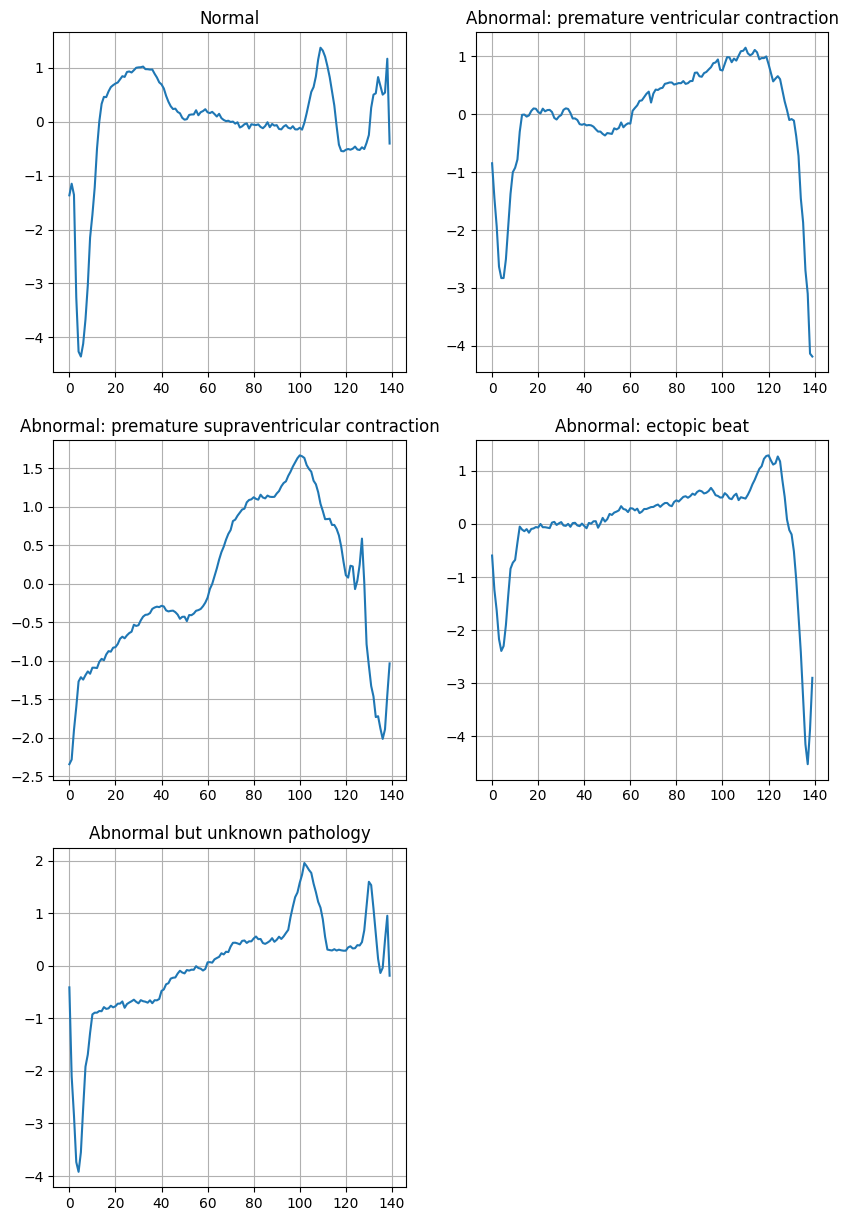

In [10]:
#Show a graphic of each category
rand_ind = 12

normal = x_train_1[rand_ind]
anormal_2 = x_train_2[rand_ind]
anormal_3 = x_train_3[rand_ind]
anormal_4 = x_train_4[rand_ind]
anormal_5 = x_train_5[rand_ind]

plt.figure(figsize=(10,15))

plt.subplot(3,2,1)
plt.title('Normal')
plt.grid()
plt.plot(np.arange(140), normal)

plt.subplot(3,2,2)
plt.title('Abnormal: premature ventricular contraction')
plt.grid()
plt.plot(np.arange(140), anormal_2)

plt.subplot(3,2,3)
plt.title('Abnormal: premature supraventricular contraction')
plt.grid()
plt.plot(np.arange(140), anormal_3)

plt.subplot(3,2,4)
plt.title('Abnormal: ectopic beat')
plt.grid()
plt.plot(np.arange(140), anormal_4)

plt.subplot(3,2,5)
plt.title('Abnormal but unknown pathology')
plt.grid()
plt.plot(np.arange(140), anormal_5)


<ipython-input-11-663131b553de>:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,1)


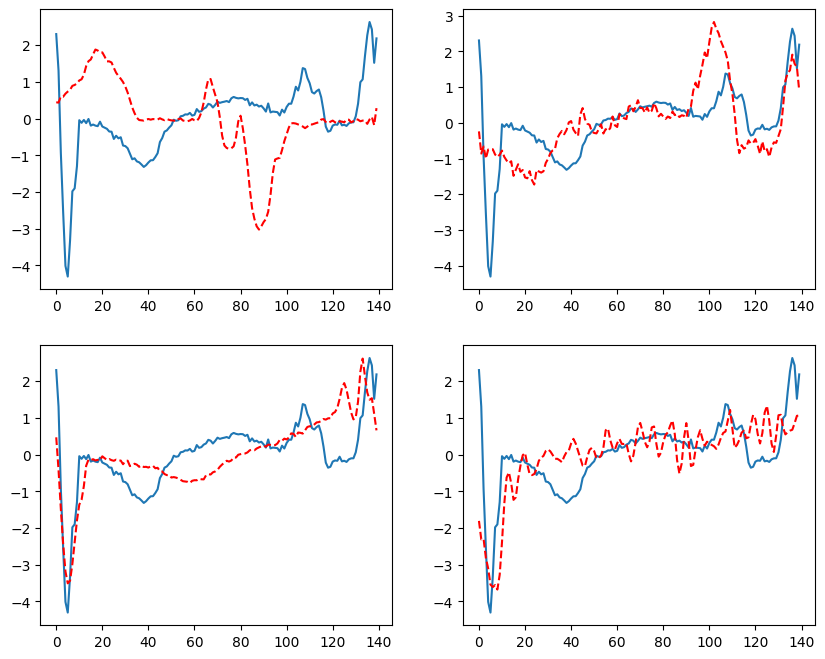

In [11]:
#Show a normal grapich with each one of the abnormal graphic to compare them
rand_ind = 5

normal = x_train_1[rand_ind]
anormal_2 = x_train_2[rand_ind]
anormal_3 = x_train_3[rand_ind]
anormal_4 = x_train_4[rand_ind]
anormal_5 = x_train_5[rand_ind]

plt.figure(figsize=(10,8))
plt.grid()

plt.subplot(2,2,1)
plt.plot(np.arange(140), normal)
plt.plot(np.arange(140), anormal_2, 'r--')

plt.subplot(2,2,2)
plt.plot(np.arange(140), normal)
plt.plot(np.arange(140), anormal_3, 'r--')

plt.subplot(2,2,3)
plt.plot(np.arange(140), normal)
plt.plot(np.arange(140), anormal_4, 'r--')

plt.subplot(2,2,4)
plt.plot(np.arange(140), normal)
plt.plot(np.arange(140), anormal_5, 'r--')

In [12]:
#Normalize the values in 0-1 range
sc = MinMaxScaler()

#We only consider the normalization for the category 1 for training
x_train_1_scaler = sc.fit_transform(x_train_1)
print('Min-max original: {:.1f}, {:.1f}'.format(np.min(x_train_1), np.max(x_train_1)))
print('Min-max normalization: {:.1f}, {:.1f}'.format(np.min(x_train_1_scaler), np.max(x_train_1_scaler)))

#We consider the normalizationf for all the categories in the test dataset since we want to see how well the model can reconstruct them
x_test_1_scaler = sc.transform(x_test_1)
print('Min-max original: {:.1f}, {:.1f}'.format(np.min(x_test_1), np.max(x_test_1)))
print('Min-max normalization: {:.1f}, {:.1f}'.format(np.min(x_test_1_scaler), np.max(x_test_1_scaler)))

x_test_2_scaler = sc.transform(x_test_2)
x_test_3_scaler = sc.transform(x_test_3)
x_test_4_scaler = sc.transform(x_test_4)
x_test_5_scaler = sc.transform(x_test_5)




Min-max original: -7.1, 5.0
Min-max normalization: 0.0, 1.0
Min-max original: -6.3, 5.0
Min-max normalization: -0.0, 1.1


In [13]:
#Create a set of validation to be included during the training
x_val_1_scaler= x_train_1_scaler[3500:]
x_train_1_scaler= x_train_1_scaler[:3500]

print(x_val_1_scaler.shape)
print(x_train_1_scaler.shape)

(927, 140)
(3500, 140)


**4. Creation of the model: Autoencoder**

In [14]:
#Random seed to be used if we want to always intit the weights of the model with the same values
np.random.seed(23)

size_input=x_train_1_scaler.shape[1]   #140 samples/example

#Input
input = Input(shape=(size_input,))

#Encoder
encoder1 = Dense(32, activation='relu')(input)
encoder2 = Dense(16, activation='relu')(encoder1)
encoder3 = Dense(8, activation='relu')(encoder2)

#Decoder
decoder1 = Dense(16, activation='relu')(encoder3)
decoder2 = Dense(32, activation='relu')(decoder1)

#Output
output = Dense(size_input, activation='sigmoid')(decoder2)

#Autoencoder
autoencoder = Model(inputs=input, outputs=output)

autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 140)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           4,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 16)                  │             144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 140)                 │           4,620 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,484 (40.95 KB)

 Trainable params: 10,484 (40.95 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

In [16]:
#Train the autoencoder
history = autoencoder.fit(
    x_train_1_scaler, x_train_1_scaler,
    epochs=50,
    batch_size=32,
    shuffle=False,
    validation_data=(x_val_1_scaler, x_val_1_scaler)
)

Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0189 - val_loss: 0.0088
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0083 - val_loss: 0.0064
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0059 - val_loss: 0.0049
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0045 - val_loss: 0.0042
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0040 - val_loss: 0.0037
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 8/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 9/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 10/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 11/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 12/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

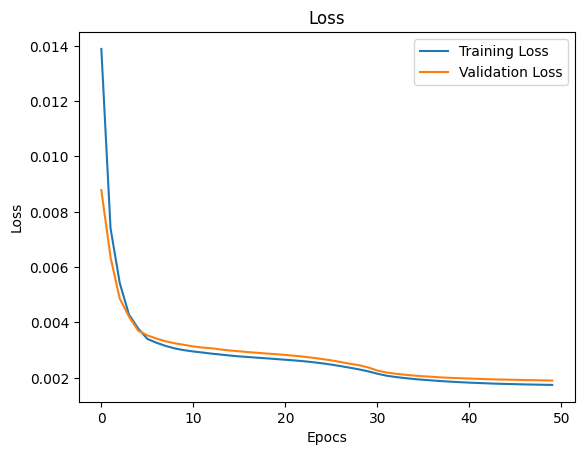

In [17]:
#Graph the Loss for training and validation to see if we have Overfitting
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epocs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
test_loss = autoencoder.evaluate(x_test_1_scaler, x_test_1_scaler)
print(test_loss)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0018 
0.0018640259513631463


**5. Classification**

In [19]:
#How well does it reconstruct "normal" and abnormal data?

rec_normal = autoencoder.predict(x_test_1_scaler)
rec_anormal = autoencoder.predict(x_test_5_scaler)

#For this, we are going to measure the error between the real and the reconstructed


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


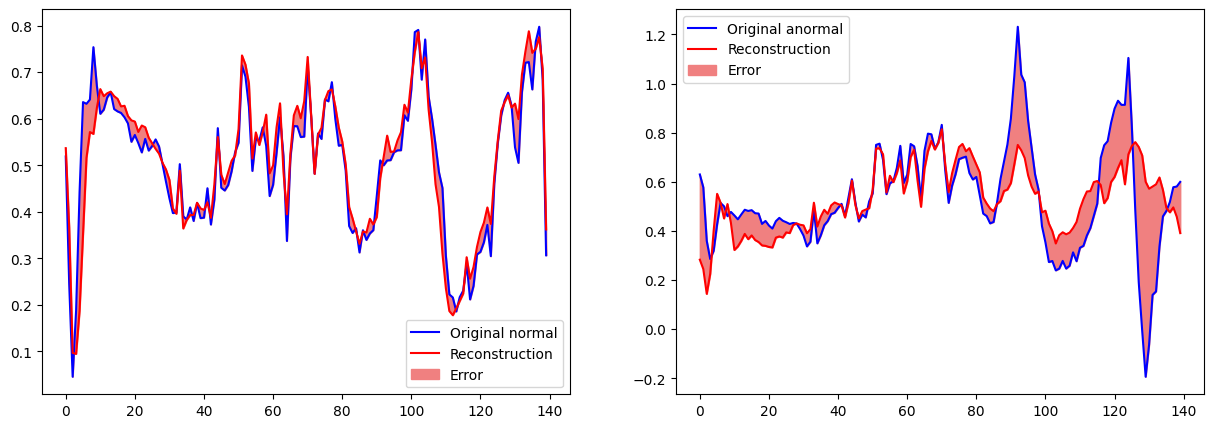

In [20]:
#Graphics
rand_ind = 6

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(x_test_1_scaler[rand_ind],'b')
plt.plot(rec_normal[rand_ind],'r')
plt.fill_between(np.arange(140), rec_normal[rand_ind], x_test_1_scaler[rand_ind], color='lightcoral')
plt.legend(labels=["Original normal", "Reconstruction", "Error"])

plt.subplot(1,2,2)
plt.plot(x_test_5_scaler[rand_ind],'b')
plt.plot(rec_anormal[rand_ind],'r')
plt.fill_between(np.arange(140), rec_anormal[rand_ind], x_test_5_scaler[rand_ind], color='lightcoral')
plt.legend(labels=["Original anormal", "Reconstruction", "Error"])

In [21]:
#Distributions of construction errors for each category

#Reconstructions using testing set
rec_1 = autoencoder.predict(x_test_1_scaler)
rec_2 = autoencoder.predict(x_test_2_scaler)
rec_3 = autoencoder.predict(x_test_3_scaler)
rec_4 = autoencoder.predict(x_test_4_scaler)
rec_5 = autoencoder.predict(x_test_5_scaler)

print(rec_1.shape)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
(1119, 140)


In [22]:
#Calculate the loss for each category
loss_1 = tf.keras.losses.mae(rec_1, x_test_1_scaler)
loss_2 = tf.keras.losses.mae(rec_2, x_test_2_scaler)
loss_3 = tf.keras.losses.mae(rec_3, x_test_3_scaler)
loss_4 = tf.keras.losses.mae(rec_4, x_test_4_scaler)
loss_5 = tf.keras.losses.mae(rec_5, x_test_5_scaler)

print(loss_1.shape)


(1119,)


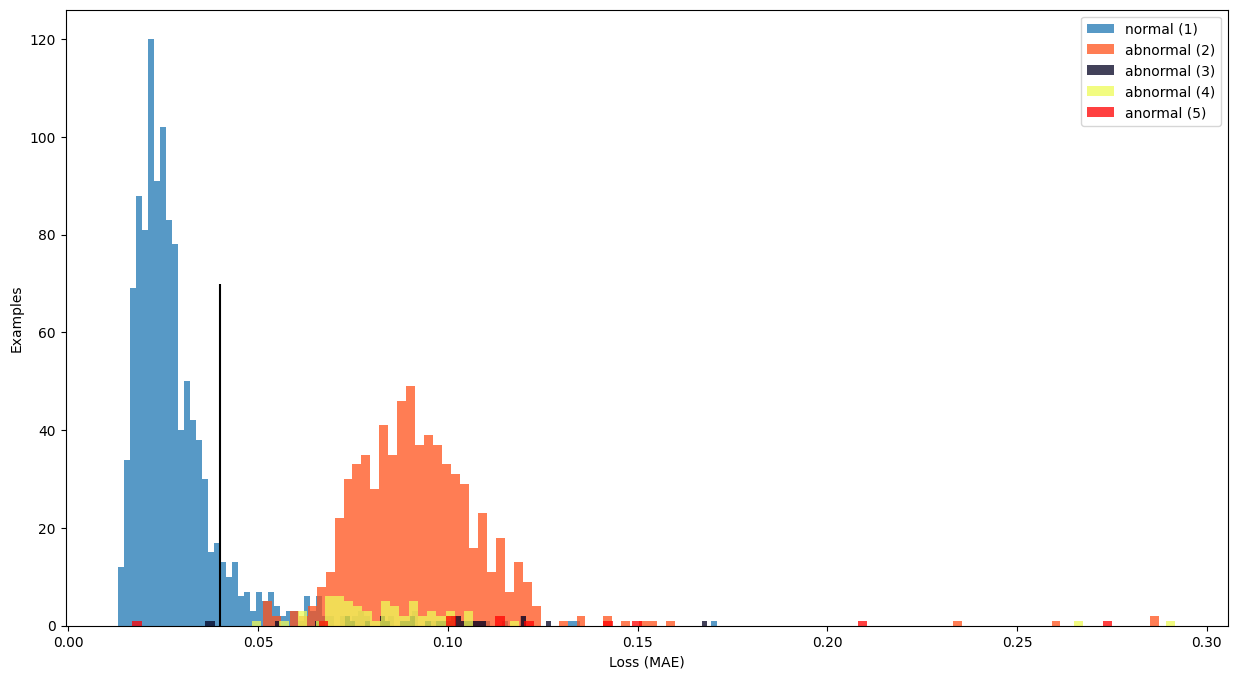

In [23]:
#Graphic of the distribution of the errors per category
plt.figure(figsize=(15,8))

plt.hist(loss_1[None,:], bins=100, alpha=0.75, label='normal (1)')
plt.hist(loss_2[None,:], bins=100, alpha=0.75, color='#ff521b', label='abnormal (2)')
plt.hist(loss_3[None,:], bins=100, alpha=0.75, color='#020122', label='abnormal (3)')
plt.hist(loss_4[None,:], bins=100, alpha=0.75, color='#eefc57', label='abnormal (4)')
plt.hist(loss_5[None,:], bins=100, alpha=0.75, color='r', label='anormal (5)')

plt.xlabel('Loss (MAE)')
plt.ylabel('Examples')
plt.legend(loc='upper right')

#We define the line at the end of the distribution of the normal category
plt.vlines(0.04,0,70,'k')




In [24]:
#This is the point (error) which will be the boundary to classify a graphic as normal or abnormal
#Error less than 0.04 -> Normal
#Error higher or equal than 0.04 -> Abnormal

umbral = np.mean(loss_1) + np.std(loss_1)
print("Umbral: ", umbral)

Umbral:  0.04378466331240809


**6. Sensitivity and specificity**

True positives (TP): Abnormals that have been correctly classified as abnormal

False negatives (FN): Abnormals that have been incorrectly classified as normal

True negatives (TN): Normals that have been correctly classified as normal

False positives (FP): Normals that have been incorrectly classified as abnormal

Sensitivity measures the proportion of abnormals that were correctly detected as abnormal. A sensitivity of 100% will detect all sick patients:

sensitivity=TP/(TP+FN)

Specificity measures the proportion of normals that were correctly detected as normal. A specificity of 100% will detect all healthy patients:

specificity=TN/(TN+FP)

In [25]:
cat1_analysis = tf.math.less(loss_1, umbral)
cat2_analysis = tf.math.less(loss_2, umbral)
cat3_analysis = tf.math.less(loss_3, umbral)
cat4_analysis = tf.math.less(loss_4, umbral)
cat5_analysis = tf.math.less(loss_5, umbral)


def sensitivity(prediction, title):

  TP = np.count_nonzero(~prediction)
  FN = np.count_nonzero(prediction)
  sen = 100*(TP/(TP+FN))
  print(title + ': {:.1f}%'.format(sen))

def specificity(prediction, title):

  TN = np.count_nonzero(prediction)
  FP = np.count_nonzero(~prediction)
  spec = 100*(TN/(TN+FP))
  print(title + ': {:.1f}%'.format(spec))

specificity(cat1_analysis,'Specificity (cat. 1, normales)')
sensitivity(cat2_analysis,'Sensitivity (cat. 2, abnormales)')
sensitivity(cat3_analysis,'Sensitivity (cat. 3, abnormales)')
sensitivity(cat4_analysis,'Sensitivity (cat. 4, abnormales)')
sensitivity(cat5_analysis,'Sensitivity (cat. 5, abnormales)')




Specificity (cat. 1, normales): 90.9%
Sensitivity (cat. 2, abnormales): 100.0%
Sensitivity (cat. 3, abnormales): 93.9%
Sensitivity (cat. 4, abnormales): 100.0%
Sensitivity (cat. 5, abnormales): 90.9%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicted category:  Abnormal
Real category:  Abnormal
Total error:  tf.Tensor([0.05069015], shape=(1,), dtype=float64)
Is the prediciton correct True


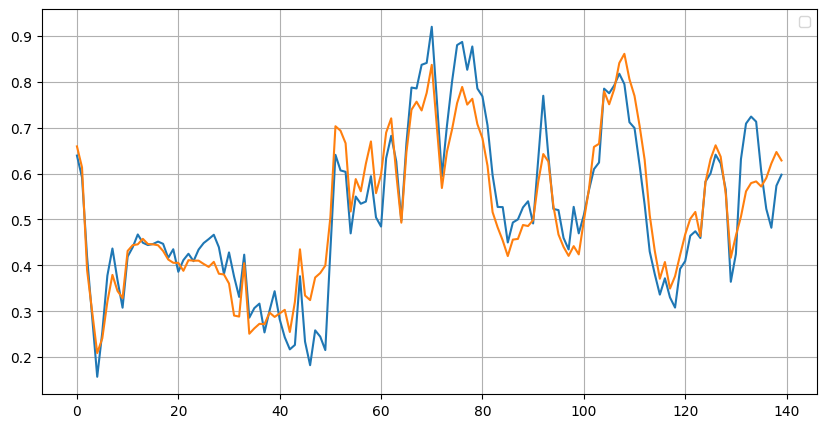

In [26]:
#Individual prediction

rand_index=42

pred_example = autoencoder.predict(x_test_1_scaler[rand_index].reshape(1,140))
loss = tf.keras.losses.mae(pred_example, x_test_1_scaler[rand_index])

if loss < umbral:
  prediction_cat = 'Normal'
else:
  prediction_cat = 'Abnormal'

if cat_test[rand_index]==1:
  real_cat = 'Normal'
else:
  real_cat = 'Abnormal'

print('Predicted category: ',prediction_cat)
print('Real category: ',real_cat)
print('Total error: ', loss)
print('Is the prediciton correct', prediction_cat==real_cat)

plt.figure(figsize=(10,5))
plt.grid()
plt.legend()

plt.plot(x_test_1_scaler[rand_index],label='Real')
plt.plot(pred_example[0],label='Predicted')

